In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import lstsq
from skimage.data import shepp_logan_phantom

In [2]:
#res in mm
res_mm = 1
#res in cm
res = 0.1
#fov in cm
fov_x = 5
fov_y = 5

pixels_x = int(fov_x/res)
pixels_y = int(fov_y/res)
pixels = pixels_x*pixels_y

t1_myelin = 400*10^-3
t1_wm = 850*10^-3
t2_myelin = 50*10^-3
t2_wm = 50*10^-3
t2_star_myelin = 30*10^-3
t2_star_wm = 70*10^-3
inv_time = np.log(2)*t1_wm
echo_time = 5*10^-5

0.45138745911337647
0.0
0.22569372955668823


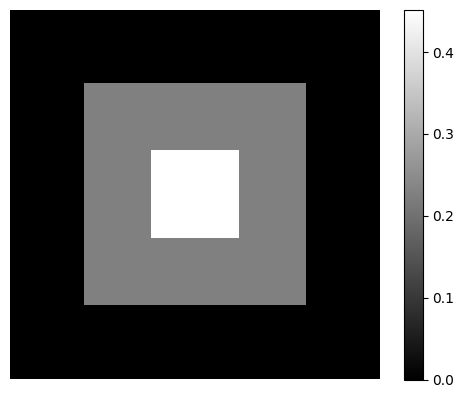

In [3]:
image = np.ones((pixels_x, pixels_y))

mxy_myelin = (1-2*np.exp(-(inv_time/t1_myelin)))*np.exp(-(echo_time/t2_star_myelin))
mxy_wm = (1-2*np.exp(-(inv_time/t1_wm)))*np.exp(-(echo_time/t2_star_wm))
mxy_mixed = 0.5*((1-2*np.exp(-(inv_time/t1_wm)))*np.exp(-(echo_time/t2_star_wm))) + 0.5*((1-2*np.exp(-(inv_time/t1_myelin)))*np.exp(-(echo_time/t2_star_myelin)))

print(mxy_myelin)
print(mxy_wm)
print(mxy_mixed)

outer_square_size = int(1.0 * pixels_x) 
middle_square_size = int(0.6 * pixels_x)
inner_square_size = int(0.25 * pixels_x)  

# Calculate starting and ending indices for each square to center them
outer_start = (pixels_x - outer_square_size) // 2
outer_end = outer_start + outer_square_size

middle_start = (pixels_x - middle_square_size) // 2
middle_end = middle_start + middle_square_size

inner_start = (pixels_x - inner_square_size) // 2
inner_end = inner_start + inner_square_size

# Define the intensity values for each section
# Outermost square (100% WM - white, intensity = 1)
image[outer_start:outer_end, outer_start:outer_end] = mxy_wm  # 100% WM

# Middle square (50/50 of WM and myelin - medium gray)
image[middle_start:middle_end, middle_start:middle_end] = mxy_mixed  # 50/50 of WM and myelin (gray)

# Innermost square (100% myelin - black, intensity = 0)
image[inner_start:inner_end, inner_start:inner_end] = mxy_myelin  # 100% myelin (black)

# image = shepp_logan_phantom()
# pixels_x = 400
# pixels_y = 400

# Display the image using matplotlib
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.axis('off')  # Turn off axis
plt.colorbar()
plt.show()



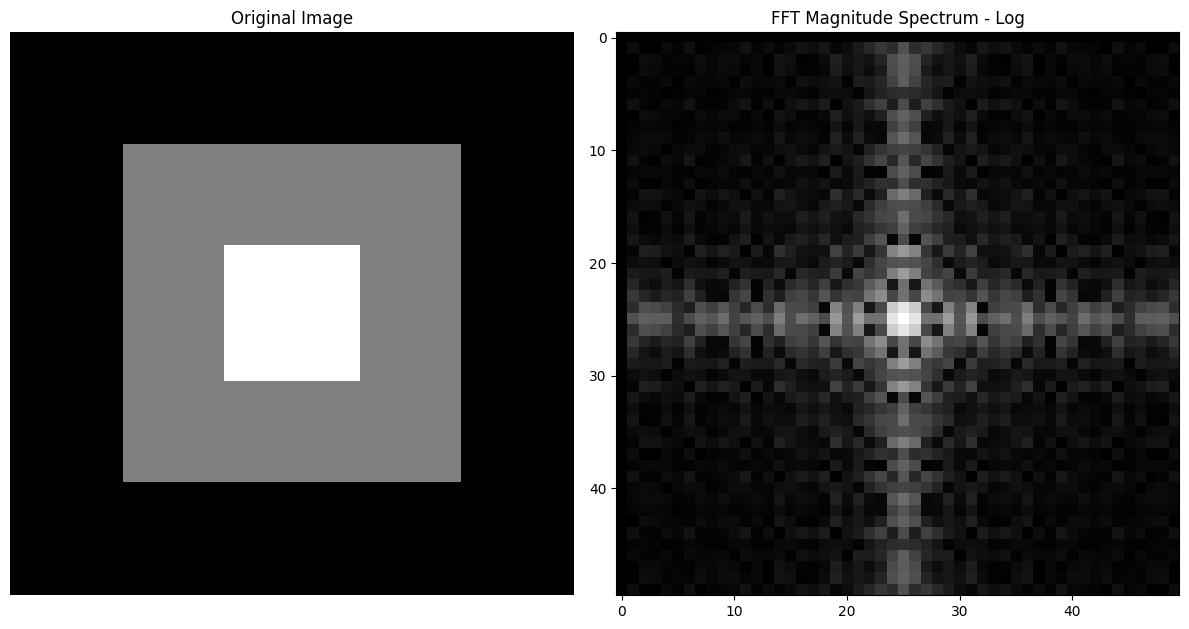

In [4]:
f_image = np.fft.fft2(image)

fft_image_shifted = np.fft.fftshift(f_image)  # Shift the zero-frequency component to the center

# Compute the magnitude spectrum
magnitude_spectrum = np.log(np.abs(fft_image_shifted) + 1)  # Log to enhance visibility

# Plot the original image and its FFT magnitude spectrum
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("FFT Magnitude Spectrum - Log")
plt.imshow(magnitude_spectrum, cmap='gray')

plt.tight_layout()
plt.show()

Shape of k_space: (2000,)


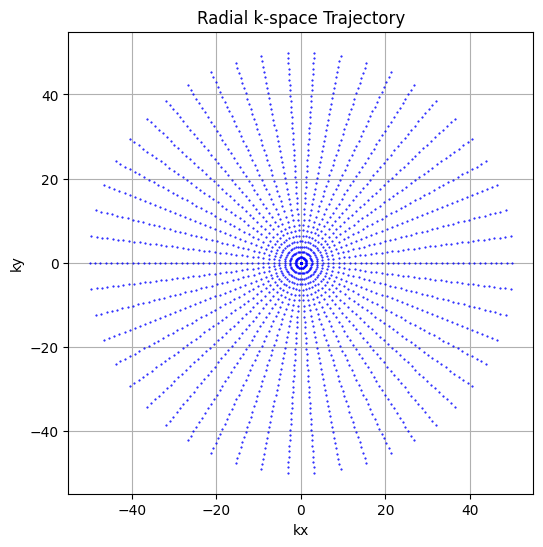

In [5]:
# Reset parameters for radial k-space sampling
#num_rays = int(np.pi*pixels_x*fov_x)+1 # Number of rays
num_rays = 50
num_samples_per_ray = 40 # Number of samples per ray

# Initialize an empty k-space list to store sampled points
k_space = np.zeros((num_rays * num_samples_per_ray,), dtype=complex)

# Create radial k-space sampling points (rays)
angles = np.linspace(0, 2 * np.pi, num_rays, endpoint=False)  # Angle of the rays
radii = np.linspace(0, pixels_x // 2, num_samples_per_ray)  # Radial distance (from the center)

# Prepare spatial coordinates
x_coords = np.arange(pixels_x)
y_coords = np.arange(pixels_y)
x_grid, y_grid = np.meshgrid(x_coords, y_coords)  # Create a grid of image coordinates

# Flatten the image for efficient computation
image_flattened = image.flatten()

# Loop over rays to calculate Fourier coefficients
index = 0
kx_values = []
ky_values = []
for angle in angles:
    for radius in radii:
        # Calculate the kx, ky coordinates for each sampled point
        kx = radius * np.cos(angle)  # x-component in frequency domain
        ky = radius * np.sin(angle)  # y-component in frequency domain

        # Store kx and ky for density compensation
        kx_values.append(kx)
        ky_values.append(ky)
        
        # Compute the Fourier coefficient for this (kx, ky)
        k_space[index] = np.sum(image_flattened * np.exp(-1j * 2 * np.pi * (kx * x_grid.flatten() / pixels_x + ky * y_grid.flatten() / pixels_y)))
        index += 1

# Convert kx_values and ky_values to numpy arrays
kx_values = np.array(kx_values)
ky_values = np.array(ky_values)

# k_space now contains the Fourier coefficients for all sampled locations
print("Shape of k_space:", k_space.shape)

# Visualize the radial k-space sampling points (this shows the rays)
plt.figure(figsize=(6, 6))
for angle in angles:
    x_vals = np.linspace(0, 50 * np.cos(angle), num_samples_per_ray)
    y_vals = np.linspace(0, 50 * np.sin(angle), num_samples_per_ray)
    plt.plot(x_vals, y_vals, 'b.', markersize=1)
plt.title('Radial k-space Trajectory')
plt.xlabel('kx')
plt.ylabel('ky')
plt.axis('equal')
plt.grid(True)
plt.show()

In [6]:
# Parameters
N_x = pixels_x  # Example value for the spatial dimension
N_k = num_rays*num_samples_per_ray

#print(k_space)

# Generate x- and y-coordinates with "isocentre" at the N_x/2+1 index
xidx, yidx = np.meshgrid(np.arange(-N_x/2, N_x/2), np.arange(-N_x/2, N_x/2))

# Loop over each k-location to construct the spatial phase modulation
F = np.zeros((N_k, N_x, N_x), dtype=complex)

for k_index in range(0, N_k- 1):
    kx = np.real(k_space[k_index])
    ky = np.imag(k_space[k_index])
    F[k_index, :, :] = np.exp(1j * 2 * np.pi * (kx * xidx + ky * yidx))

# Reshape F so that each row is a single k-space encoding
print(F.shape)
F = F.reshape(N_k, -1)
reshaped_image = image.reshape(-1)
#dot product
d = F @ reshaped_image
print(F.shape)
print(d.shape)



(2000, 50, 50)
(2000, 2500)
(2000,)


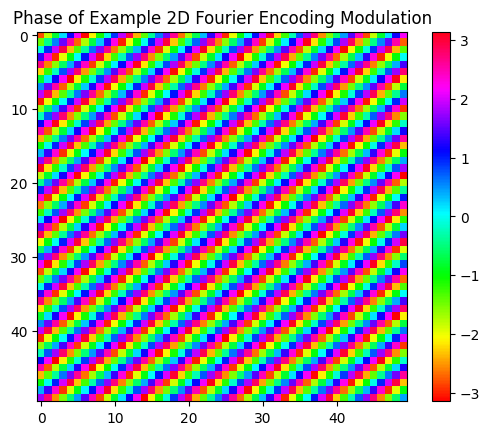

In [7]:
# Show an example encoding (using the 2000th row)
example_encoding = F[2, :]

# Reshape the encoding to a 2D array (N_x x N_x)
example_encoding_2d = np.reshape(example_encoding, (N_x, N_x))

# Plotting the phase of the 2D Fourier Encoding Modulation
plt.figure()
plt.imshow(np.angle(example_encoding_2d), cmap='hsv', vmin=-np.pi, vmax=np.pi)
plt.title('Phase of Example 2D Fourier Encoding Modulation')
plt.colorbar()
plt.show()

Shape of F: (2500, 2000)
Shape of d: (2000,)
Shape of x_reconstructed: (2500,)
Shape of image_reconstructed: (50, 50)


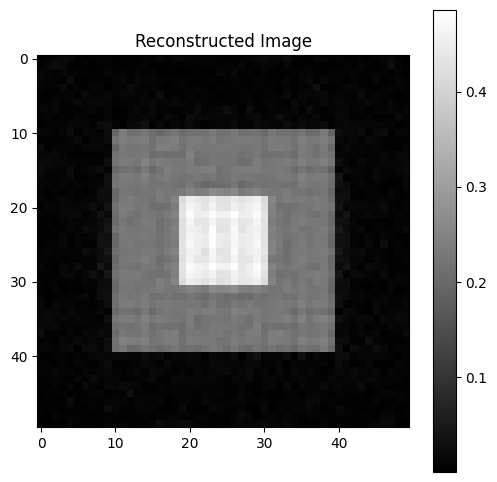

NRMSE (Direct Inverse): 0.0765


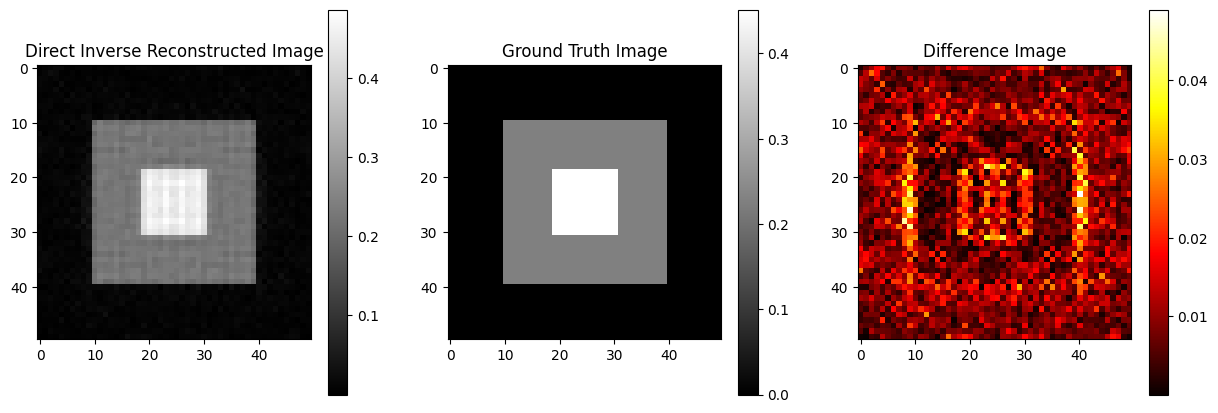

In [8]:
# Compute the naive inverse using NumPy (similar to F \ d in MATLAB)

# Reconstruction using pseudo-inverse
x_reconstructed = np.linalg.pinv(F) @ d  # Reconstruct the i-th image

print("Shape of F:", np.linalg.pinv(F).shape)  # Should be (N_x^2, N_k)
print("Shape of d:", d.shape)                 # Should be (N_k,)
print("Shape of x_reconstructed:", x_reconstructed.shape)  # Should be (N_x^2,)

#average_image = np.mean(x_reconstructed, axis=1) 

# Reshape the 1D vector to 2D
image_reconstructed = x_reconstructed.reshape(N_x, N_x)
#image_reconstructed = average_image.reshape(N_x, N_x)
print("Shape of image_reconstructed:", image_reconstructed.shape)  # Should be (N_x, N_x)
#print("Shape of image_reconstructed:", average_image.shape)  # Should be (N_x, N_x)

# Visualize
plt.figure(figsize=(6, 6))
plt.imshow(np.abs(image_reconstructed), cmap='gray')
plt.colorbar()
plt.title('Reconstructed Image')
plt.show()

def compute_nrmse(est, ground_truth):
    """Compute the Normalized Root Mean Square Error (NRMSE)."""
    # Use the absolute values for complex images
    est_abs = np.abs(est)
    ground_truth_abs = np.abs(ground_truth)
    return np.sqrt(np.mean((est_abs - ground_truth_abs) ** 2)) / np.sqrt(np.mean(ground_truth_abs ** 2))

def display_results(est, ground_truth, N_x, title):
    """Display the reconstructed image, ground truth, and difference image."""
    est_image = np.abs(est).reshape(N_x, N_x)
    ground_truth_image = np.abs(ground_truth).reshape(N_x, N_x)
    diff_image = np.abs(est_image - ground_truth_image)

    plt.figure(figsize=(15, 5))

    # Reconstructed image
    plt.subplot(1, 3, 1)
    plt.imshow(est_image, cmap='gray')
    plt.colorbar()
    plt.title(f'{title} Reconstructed Image')

    # Ground truth
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_image, cmap='gray')
    plt.colorbar()
    plt.title('Ground Truth Image')

    # Difference image
    plt.subplot(1, 3, 3)
    plt.imshow(diff_image, cmap='hot')
    plt.colorbar()
    plt.title('Difference Image')

    plt.show()


# Flatten for comparison
true_image_flat = image.flatten()
reconstructed_image_flat = image_reconstructed.flatten()

# Compute NRMSE
nrmse_value = compute_nrmse(reconstructed_image_flat, true_image_flat)
print(f'NRMSE (Direct Inverse): {nrmse_value:.4f}')

# Display images
display_results(reconstructed_image_flat, true_image_flat, N_x, 'Direct Inverse')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pynufft import NUFFT

oversampling_factor = 2
kernel_size = (6, 6)

print(kx_values.shape)
print(ky_values.shape)
print(k_space.shape)

# Create NUFFT object
nufft_obj = NUFFT()
om = np.stack((kx_values, ky_values), axis=-1)
Kd = (oversampling_factor * pixels_x, oversampling_factor * pixels_y)
nufft_obj.plan(om, (pixels_x, pixels_y), Kd, kernel_size)

# Perform NUFFT adjoint reconstruction
reconstructed_image = nufft_obj.adjoint(k_space)

# Visualize Results
plt.figure(figsize=(18, 6))

# Original Image (display the input image)
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.colorbar()

# Radial k-space Trajectory
plt.subplot(1, 3, 2)
plt.title("Radial k-space Trajectory")
plt.plot(kx_values, ky_values, 'b.', markersize=1)
plt.xlabel('kx')
plt.ylabel('ky')
plt.axis('equal')
plt.grid(True)

# Display the reconstructed image
plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
plt.imshow(np.abs(reconstructed_image), cmap='gray')
plt.colorbar()

plt.show()